<a href="https://colab.research.google.com/github/arjygh/stocksandoptions/blob/Working_AG/stonks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#optional installations: 
!pip install yfinance --upgrade --no-cache-dir
# !pip3 install pandas_datareader
# !pip3 install matplotlib


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import ssl
from urllib import request
#dummy change


#newest yahoo API 
import yfinance as yahoo_finance

#optional 
yahoo_finance.pdr_override()

%matplotlib inline

     |████████████████████████████████| 5.5MB 8.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=330a291d3a37b6d5e99a04ecf164d5d9af9ba68388cd164bc2834cb92ca77908
  Stored in directory: /tmp/pip-ephem-wheel-cache-3f0tv56o/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
def computeRSI (dataframe, time_window):
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
    return df

def CBI_func(ticker,start_time, end_time,trade_date):
    """
    ticker - S&P500 ticker for which stock prices are obtained
    start_time - earliest date at which the stock_price is obtained from yfinance
    end_time - latest date at which the stock price is obtained from yfinance
    trade_date - a date between the start_time and end_time at which a hypothetical trade is entered

    All Technical Indicators are calculated with the "PAST" data and Price changes are calculated with the "FUTURE" data as defined below:
    start_time........................trade_date..........................end_time
    [..............PAST..............]          [...........FUTURE...............]

    CBI [Cumulative Buying Index]:
    - Average of scores calculated from value on trade date, slope and intercept of 'x' days before the trade date of the following Indicators: 
      - Stochastic slow - 14 day average
      - MACD Divergence - standard 12,26,9 day
    - Values closer to zero are strong indicators and the distance from zero defines the strength of the indicator, however, within small intervals 
      distance from zero may not necessarily correlate with strength. For eg: 
        - CBI of 0.1 and 0.5 is highly likely to indicate strong and weak buy respectively
        - CBI of 0.1 and 0.15 may not indicate that the former is a stronger buy than the latter

    """
    
    
    #DEFINE ALL INPUT VARIABLES
    holding_days = 15 #Number of days in future from the trade date within which change in price of the stock (price_delta) will be calculated
    vol_avg_window = 15 #Number of days in the past over which average traded volume is obtained




    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
        except Exception as e:
            print("Ticker: ", ticker,"  >>  Error: " + str(e))
            # time.sleep( 5 )
            continue 
    
    ticker_df = ticker_df.reset_index()
    
    #Get Stock Prices for the ticker between start_time and end_time
    df0 = ticker_df
    #Call functions to calculate the Technical Indicators for each date (row) in the dataframe,...
    #append as columns to the same dataframe                                                                            
    df0['RSI'] = computeRSI(df0['Adj Close'], 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0,'Close',12,26,9)

    #DEFINE TRADE DATE
    day0 = trade_date #.............Date to enter a trade
    trade_date_delta = len(df0.index) - df0[df0['Date']==day0].index.values
    trade_date_price = df0['Close'].iloc[-1*trade_date_delta]    #.........Closing price of the stock on trade_Date
    
    

    #CALCULATE CHANGE IN PRICE IN FUTURE WITHIN THE INTERVAL [trade_date, trade_date+holding_days]
    mask = df0['Date'].between(day0,(day0.date() + datetime.timedelta(days = min(7,trade_date_delta))).isoformat())
    max_price = df0.loc[mask,'Close'].max()
    
    Price_delta = 100*(max_price - trade_date_price)/trade_date_price
    df = df0[(df0["Date"] <= day0)] #.........Extract part of the dataframe from 'start_time' to 'trade_date' into a new dataframe
    print("Analyzing Ticker: ", ticker, " for trade date: ", day0)

    CBIL = [] #Call Buying Indicator List
    

    avg_volume = avg_volume_in_window(df, 15, day0)
    # print("Avg Vol:", avg_volume)
    
    #trade date values
    RSI_val = df[df['Date']==day0]['RSI'].values
    MACD_Div_val = df[df['Date']==day0]['MACD_Div'].values
    d_slow_val = df[df['Date']==day0]['d_slow'].values
    # print("RSI_val:", RSI_val)

    
    #slopes
    RSI_fit = slope_calculator(df, 7, day0,'RSI') #num_days >=3
    MACD_Div_fit = slope_calculator(df,4,day0,'MACD_Div') #num_days >=3
    d_slow_fit = slope_calculator(df,4,day0,'d_slow') #num_days >=3
    # print("Slopes:", RSI_fit,MACD_Div_fit,d_slow_fit)


    vol_limit = 2e6

    if avg_volume > vol_limit and RSI_val > 40 and RSI_val < 75 and RSI_fit[0] > 0:
      CBIL.append(day0)

      # #RSI values: 
      # AllRSI = np.array([df[df['Date']==day0]['RSI'].values,df[df['Date']==day1]['RSI'].values,df[df['Date']==day2]['RSI'].values])
      # #d_slow values: 
      # AllSS = np.array([df[df['Date']==day0]['d_slow'].values,df[df['Date']==day1]['d_slow'].values,df[df['Date']==day2]['d_slow'].values])
      # #d_fast values
      # AllSF = np.array([df[df['Date']==day0]['d_fast'].values,df[df['Date']==day1]['d_fast'].values,df[df['Date']==day2]['d_fast'].values])
      # #d_div values
      # AllSD = np.array([df[df['Date']==day0]['d_div'].values,df[df['Date']==day1]['d_div'].values,df[df['Date']==day2]['d_div'].values])
      # #MACD_Div values
      # AllMD = np.array([df[df['Date']==day0]['MACD_Div'].values,df[df['Date']==day1]['MACD_Div'].values,df[df['Date']==day2]['MACD_Div'].values])

      # row = df[df['Date']==end_time]['d_slow'].values
      # print(df['Date'].iloc[-1])
      # print(AllRSI, AllSS, AllSF, AllMD)

      #Algorithm for entry ot exit
    

      #RSI Score
      # if AllRSI[0] > 50 and AllRSI[0] < 75:
      #   CBIL.append((abs(AllRSI[0] - 50)/25).item())
      # else: 
      #   CBIL.append(1.0)
      
      ##SS score
      # SS7DayDiv = AllSS[0] - AllSS[1] #use only when there is an increasing trend
      # if AllSS[0] > 20 and AllSS[0]< 40 and SS7DayDiv > 0:
      #   CBIL.append((abs(AllSS[0]-30)/10).item())
      # else:
      #   CBIL.append(1.0)
      
      # TECHNICAL INDICATORS ALGEBRA #
      if d_slow_val > 10 and d_slow_val < 50 and d_slow_fit[0] > 0:
        CBIL.append((abs(d_slow_val-30)/20).item())
      else: 
        CBIL.append(10.0)

      if MACD_Div_val < 0 and MACD_Div_fit[1] < 0 and MACD_Div_fit[0] > 0:
        CBIL.append(MACD_Div_val/MACD_Div_fit[1])
      else: 
        CBIL.append(10.0)

          

      # #MACD_Div
      # AllMDDiv = abs(AllMD[1]) - abs(AllMD[0])
      # if AllMD[0] < 0 and AllMD[1] < 0 and abs(AllMD[1]) > abs(AllMD[0]):
      #   CBIL.append((1-(abs(AllMD[1]) - abs(AllMD[0]))/abs(AllMD[1])).item())
      # else:
      #   CBIL.append(1.0)
      
      CBIL.append(trade_date_price)
      CBIL.append(Price_delta)
      CBI = (sum(CBIL[1:2])/2.0)
      CBIL.append(CBI)
      
      if CBI < 0.25:
          print("\nTICKER: ", ticker, "\t","Trade Date: ", day0)
          print("$$$$$ CBI = ",CBI,"$$$$$")
          print("_________________________________")
          print("RSI = ", RSI_val,RSI_fit)
          print("Stochastic Slow =", d_slow_val,d_slow_fit)
          print("MACD Div =", MACD_Div_val,MACD_Div_fit)
          print("Average Volume =", avg_volume)
          print("_________________________________")
    else:
      print("Low Volume or RSI out of bounds")

    print("\n\n")        
    return CBIL

def avg_volume_in_window(dataframe, num_days, trade_date):
  df = dataframe.copy()
  df['Date'] = pd.to_datetime(df['Date'])

  # start_time = (trade_date.date() - datetime.timedelta(days = num_days)).isoformat()
  # df = df[(df["Date"] > start_time)]
  # print("vol: ", df["Volume"].iloc[-1*num_days:-1].mean(axis=0))
  return df["Volume"].iloc[-1*num_days:-1].mean(axis=0)

def slope_calculator(dataframe, num_days, trade_date,indicator):
  if num_days < 3:
    print("\nError: num_days should be more than or equal to 3\n")
    exit()
  df = dataframe.copy()
  df['Date'] = pd.to_datetime(df['Date'])
  

  # start_time = (trade_date.date() - datetime.timedelta(days = num_days)).isoformat()
  # df = df[(df["Date"] > start_time)]
  # print(df[indicator].iloc[-1*num_days])
  # print(df[indicator].iloc[-1])
  Y = np.array(df[indicator].iloc[-1*num_days:-1])
  X = np.array([n for n in range(0, len(Y))])
  Z = np.polyfit(X,Y,1)
  return Z
  






In [3]:
start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
end_time = datetime.datetime.now().date().isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

ticker_list = ['DD']
trade_days_min = '2021-02-25'
trade_days_max = '2021-03-15'
test_days = pd.bdate_range(trade_days_min, trade_days_max)
print(test_days)

#CBI_all = []
for ticker in ticker_list: 
  for days in test_days:
      CBIL = CBI_func(ticker, start_time, end_time, days)
      if len(CBIL) > 0:
        print(CBIL, ";", sum(CBIL[1:3])/2.0)

Start Date:  2021-01-11
End Date:  2021-04-11
DatetimeIndex(['2021-02-25', '2021-02-26', '2021-03-01', '2021-03-02',
               '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-08',
               '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
               '2021-03-15'],
              dtype='datetime64[ns]', freq='B')
[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  DD  for trade date:  2021-02-25 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  DD  for trade date:  2021-02-26 00:00:00

TICKER:  DD 	 Trade Date:  2021-02-26 00:00:00
$$$$$ CBI =  0.02383347191977938 $$$$$
_________________________________
RSI =  [40.35229501] [ 1.95048938 28.95559616]
Stochastic Slow = [29.04666112] [ 5.43846119 12.10704806]
MACD Div = [0.17313168] [ 0.17159471 -0.24364046]
Average Volume = 8567514.285714285
_________________________________



[Timestamp('2021-02-26

    Symbol             Security SEC filings             GICS Sector                   GICS Sub-Industry    Headquarters Location Date first added      CIK      Founded
0      MMM           3M Company     reports             Industrials            Industrial Conglomerates      St. Paul, Minnesota       1976-08-09    66740         1902
1      ABT  Abbott Laboratories     reports             Health Care               Health Care Equipment  North Chicago, Illinois       1964-03-31     1800         1888
2     ABBV          AbbVie Inc.     reports             Health Care                     Pharmaceuticals  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)
3     ABMD              Abiomed     reports             Health Care               Health Care Equipment   Danvers, Massachusetts       2018-05-31   815094         1981
4      ACN            Accenture     reports  Information Technology      IT Consulting & Other Services          Dublin, Ireland       2011-07-06  1467373      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Analyzing Ticker:  MMM  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ALK  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ALLE  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAL  for trade date:  2021-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AME  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AOS  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  BA  for trade date:  2

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  CNC  for trade date:  2021-03-01 00:00:00

TICKER:  CNC 	 Trade Date:  2021-03-01 00:00:00
$$$$$ CBI =  0.12631568267928853 $$$$$
_________________________________
RSI =  [44.47440623] [ 1.11133213 35.92541494]
Stochastic Slow = [35.05262731] [ 5.42624752 25.36481582]
MACD Div = [0.29606308] [-0.0065024   0.26482711]
Average Volume = 3844557.1428571427
_________________________________



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CERN  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds





/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CI  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  COO  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CVS  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  DHR  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  DVA  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  XRAY  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  DXC  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ENPH  for trade date:  2021-03-01 00:00:00

TICKER:  ENPH 	 Trade Date:  2021-03-01 00:00:00
$$$$$ CBI =  0.077129219564633 $$$$$
_________________________________
RSI =  [49.00122475] [ 0.06724971 40.68959365]
Stochastic Slow = [33.08516878] [ 5.27191515 18.93949206]
MACD Div = [-1.01618826] [ 0.01993714 -2.30555281]
Average Volume = 3765600.0
_________________________________



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FFIV  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds





/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FIS  for trade date:  2021-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FISV  for trade date:  2021-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FLT  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FLIR  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FTNT  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  IT  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Ana

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  LYV  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  LUMN  for trade date:  2021-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NFLX  for trade date:  2021-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NWSA  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  NWS  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  OMC  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
An

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)



Analyzing Ticker:  TWTR  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  VZ  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  VIAC  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  DIS  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AAP  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  AMZN  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  BLK  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  COF  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CBOE  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  SCHW  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CB  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CINF  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*******

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  EMN  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  ECL  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FMC  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  FCX  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  IP  for trade date:  2021-03-01 00:00:00



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  IFF  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%*****************

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CPB  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CHD  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CLX  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  KO  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CL  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[*********************100%***********************]  1 of 1 completed
Analyzing Ticker:  CAG  for trade date:  2021-03-01 00:00:00
Low Volume or RSI out of bounds



[***********

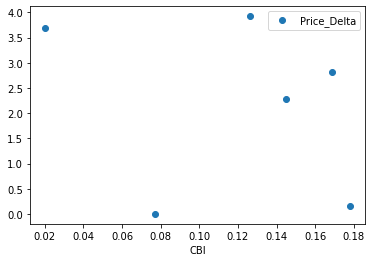

In [4]:
url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
print (sp500)
sp500 = sp500[['Symbol','Security','GICS Sector']]
# sp500 = sp500.head(5)

# filename = 'constituents_csv.csv'
# sp500 = pd.read_csv(filename)
# sp500['CBI_RSI']= np.nan
sp500['CBI_SS']= np.nan
sp500['CBI_MACD']= np.nan
sp500['CBI'] = np.nan
sp500['t-30price'] = np.nan
sp500['Price_Delta'] = np.nan
sp500['Trade_Date'] = np.nan
sp500 = sp500[sp500['Symbol'] != "."]
# sp500 = sp500.head(100)

# sp500.groupby(['GICS Sector']).count()
# df2['CBI'] = CBI_func(df2['Symbol'],start_time,end_time)

# start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

#
sector_list = list(sp500['GICS Sector'].unique())
#ticker_list = list(sp500['Symbol'])
passed_tickers=[]
no_data_tickers = []
trade_date = datetime.datetime(2021, 3, 1)

for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    for ticker in ticker_list:
      try:
        CBIL = CBI_func(ticker, start_time, end_time, trade_date)

        if len(CBIL) > 0 and CBIL[5] < 0.25:
          sp500.loc[sp500['Symbol'] == ticker, ['Trade_Date','CBI_SS','CBI_MACD','CBI','t-30price','Price_Delta']] = [CBIL[0], CBIL[1], CBIL[2], CBIL[5],CBIL[3],CBIL[4]]
        
      except Exception as e:
        print('Analyzed Security: ',ticker, 'No Data')
        print("Ticker: ", ticker,"  >>  Error: " + str(e))
        no_data_tickers.append(ticker)
        #traceback.print_exc()
        continue


#print("CBI = ", CBI_all)
print(sp500)
print('Tickers Qualified by CBI Criteria: ', passed_tickers)
print('Tickers for which data was not obtained: ', no_data_tickers)
sp500.plot(x='CBI',y='Price_Delta',style='o')

In [5]:
# print("\n\n------- QUALIFIED BY RSI -----------")
# print(sp500[sp500['CBI_RSI'] < 0.25])

print("\n\n------- QUALIFIED BY SS -----------")
print(sp500[sp500['CBI_SS'] < 0.25])

print("\n\n------- QUALIFIED BY MACD -----------")
print(sp500[sp500['CBI_MACD'] < 0.25])

print("\n\n------- QUALIFIED BY CBI -----------")
print(sp500[sp500['CBI'] < 0.25])




------- QUALIFIED BY SS -----------
    Symbol              Security             GICS Sector    CBI_SS   CBI_MACD       CBI   t-30price  Price_Delta           Trade_Date
85     CAH  Cardinal Health Inc.             Health Care  0.040794  10.000000  0.020397   52.750000     3.696684  2021-03-01 00:00:00
167   ENPH        Enphase Energy  Information Technology  0.154258   0.440757  0.077129  186.449997     0.000000  2021-03-01 00:00:00


------- QUALIFIED BY MACD -----------
    Symbol                        Security             GICS Sector    CBI_SS  CBI_MACD       CBI  t-30price  Price_Delta           Trade_Date
116   CTSH  Cognizant Technology Solutions  Information Technology  0.355796  0.177145  0.177898  74.830002     0.160357  2021-03-01 00:00:00


------- QUALIFIED BY CBI -----------
    Symbol                        Security             GICS Sector    CBI_SS   CBI_MACD       CBI   t-30price  Price_Delta           Trade_Date
85     CAH            Cardinal Health Inc.           